In [1]:
# ===========================================
# PART 1: IMPORTS AND UTILITIES
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
import itertools
import statsmodels.api as sm
from datetime import datetime, time
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, 
    accuracy_score, mean_squared_error, mean_absolute_error, 
    median_absolute_error, r2_score
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import joblib
import warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# ---------------------- Utility Functions ----------------------
def get_season(date):
    if pd.isnull(date): 
        return None
    month = date.month
    if month in [12, 1, 2]: 
        return 'Winter'
    elif month in [3, 4, 5]: 
        return 'Spring'
    elif month in [6, 7, 8]: 
        return 'Summer'
    else: 
        return 'Autumn'

def calculate_zscore(series):
    return (series - series.mean()) / series.std()


In [2]:
# ===========================================
# PART 2: DATA LOADING AND INITIAL PREPROCESSING
# ===========================================

# ---------------------- Load Data ----------------------
ALL_PATH = '/Users/gaetanledu/Documents/CASE/ENGIE/DE/ALL.csv'
df = pd.read_csv(ALL_PATH)
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')

# ---------------------- Clean Numeric Columns ----------------------
numeric_cols = df.columns.drop('Start date')
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=['Start date'], inplace=True)

# ---------------------- Add Basic Features ----------------------
df['Season'] = df['Start date'].apply(get_season)
df['Residual Load (%)'] = (df['Residual load [MWh]'] / df['grid load [MWh]']) * 100
df['Forecast Error (%)'] = ((df['grid load [MWh] forecasted'] - df['grid load [MWh]']) / df['grid load [MWh]']) * 100


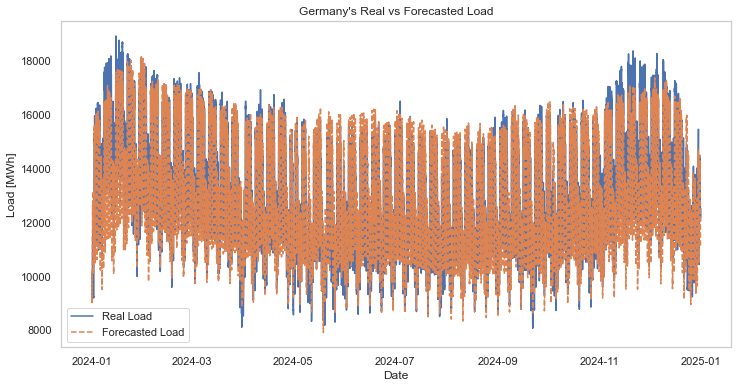

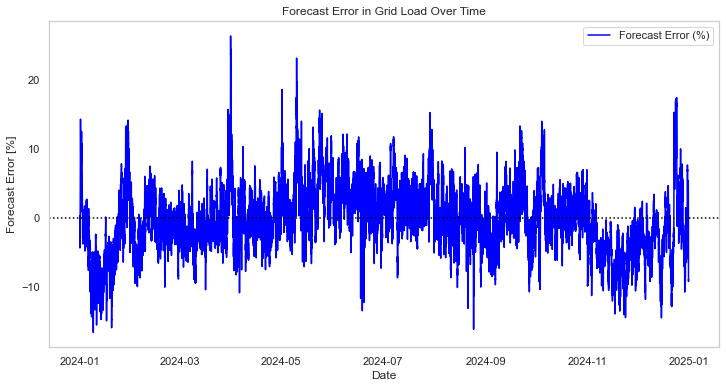

In [3]:
# ===========================================
# PART 3: LOAD FORECASTING PLOTS
# ===========================================

# ---------------------- Plot: Real vs Forecasted Load ----------------------
plt.figure(figsize=(12, 6))
plt.plot(df['Start date'], df['grid load [MWh]'], label='Real Load')
plt.plot(df['Start date'], df['grid load [MWh] forecasted'], label='Forecasted Load', linestyle='dashed')
plt.title("Germany's Real vs Forecasted Load")
plt.xlabel('Date')
plt.ylabel('Load [MWh]')
plt.legend()
plt.grid()
plt.show()

# ---------------------- Plot: Forecast Error Over Time ----------------------
plt.figure(figsize=(12, 6))
plt.plot(df['Start date'], df['Forecast Error (%)'], color='blue', label='Forecast Error (%)')
plt.axhline(0, linestyle='dotted', color='black')
plt.title("Forecast Error in Grid Load Over Time")
plt.xlabel('Date')
plt.ylabel('Forecast Error [%]')
plt.legend()
plt.grid()
plt.show()


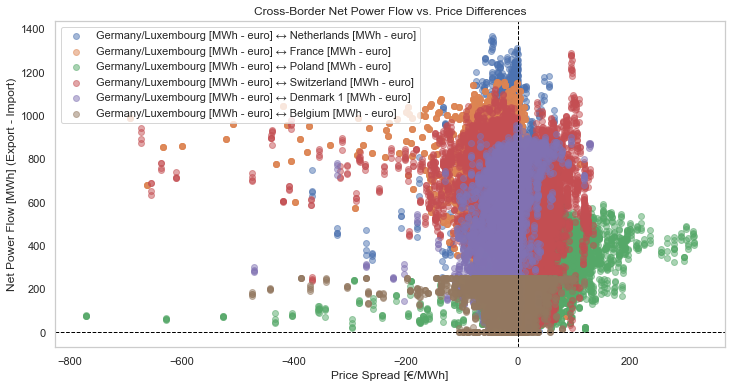


Top 10 Most Correlated Country Pairs (DA Prices):
                         Country 1                        Country 2  \
0           Denmark 2 [MWh - euro]           Denmark 1 [MWh - euro]   
1         Netherlands [MWh - euro]  Germany/Luxembourg [MWh - euro]   
2      Czech Republic [MWh - euro]             Austria [MWh - euro]   
3         Netherlands [MWh - euro]             Belgium [MWh - euro]   
4  Germany/Luxembourg [MWh - euro]           Denmark 1 [MWh - euro]   
5             Austria [MWh - euro]  Germany/Luxembourg [MWh - euro]   
6      Czech Republic [MWh - euro]  Germany/Luxembourg [MWh - euro]   
7  Germany/Luxembourg [MWh - euro]             Belgium [MWh - euro]   
8  Germany/Luxembourg [MWh - euro]           Denmark 2 [MWh - euro]   
9             Austria [MWh - euro]         Netherlands [MWh - euro]   

   Correlation  
0     0.968267  
1     0.955464  
2     0.948958  
3     0.946700  
4     0.923917  
5     0.920168  
6     0.916825  
7     0.906711  
8     0.901883

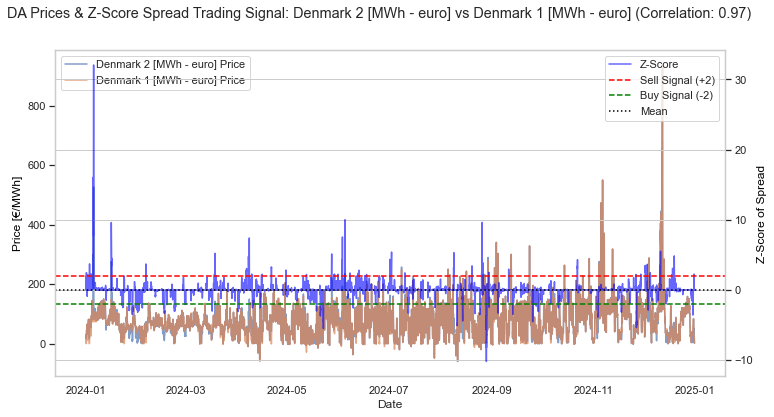

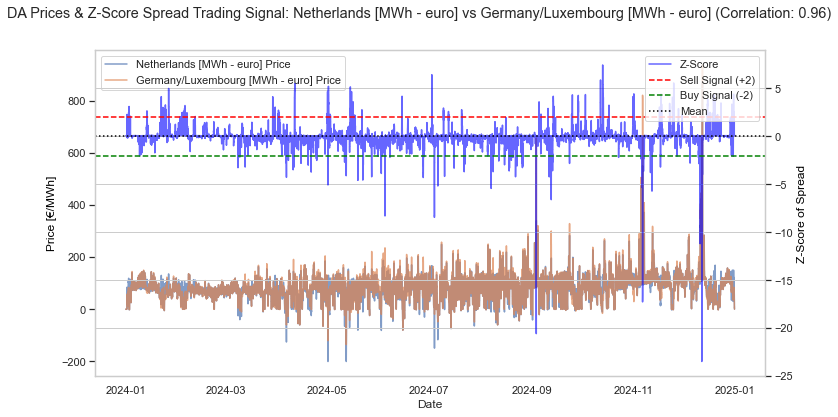

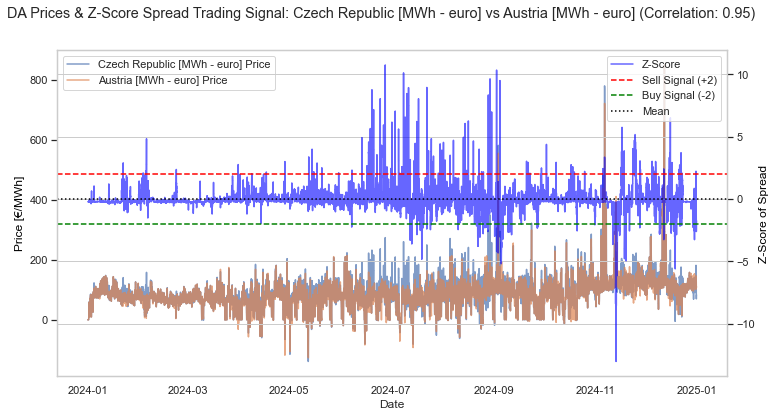

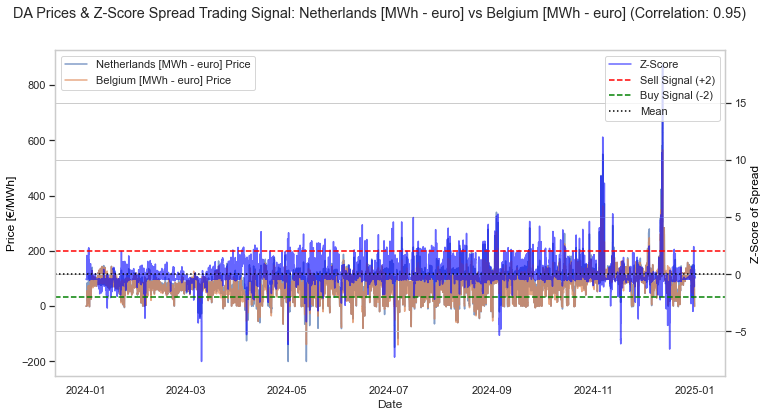

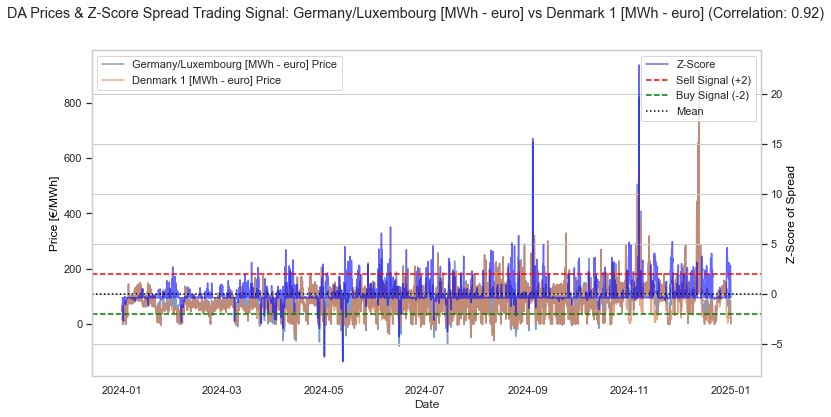

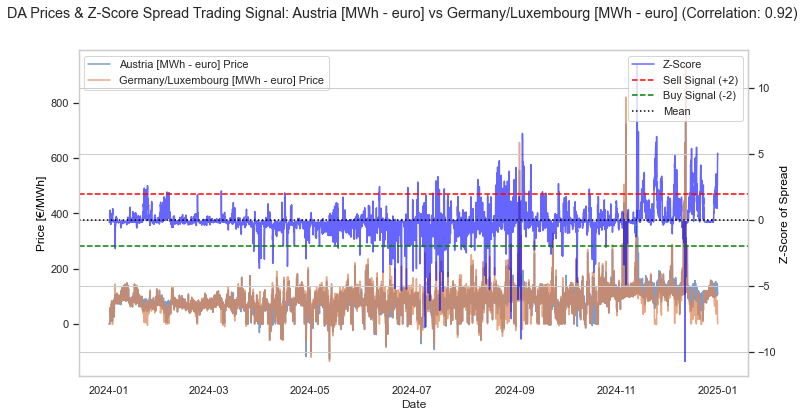

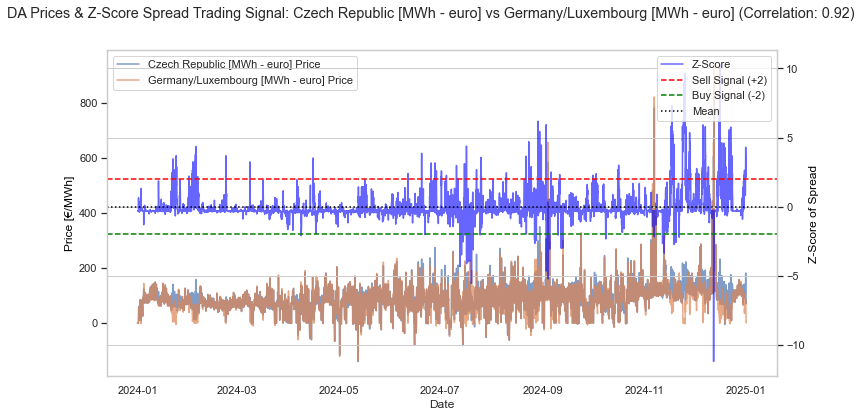

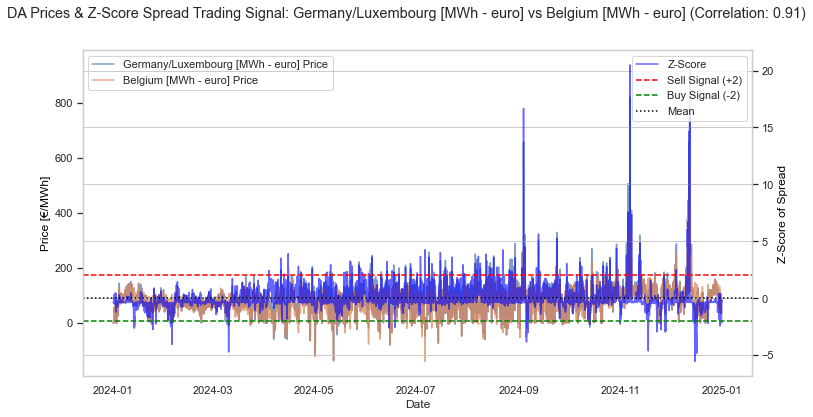

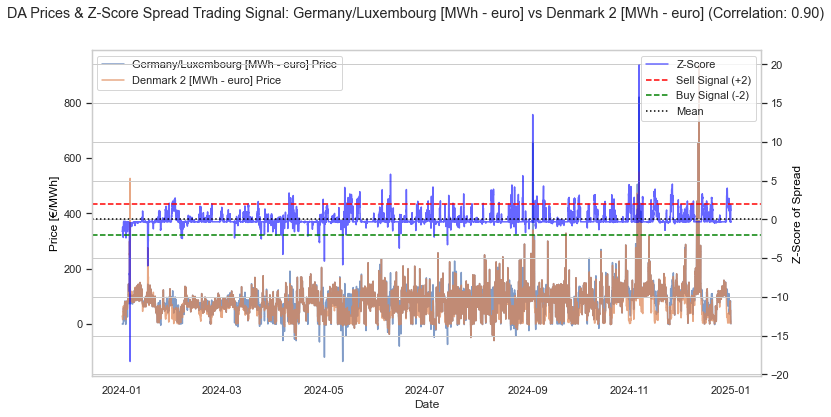

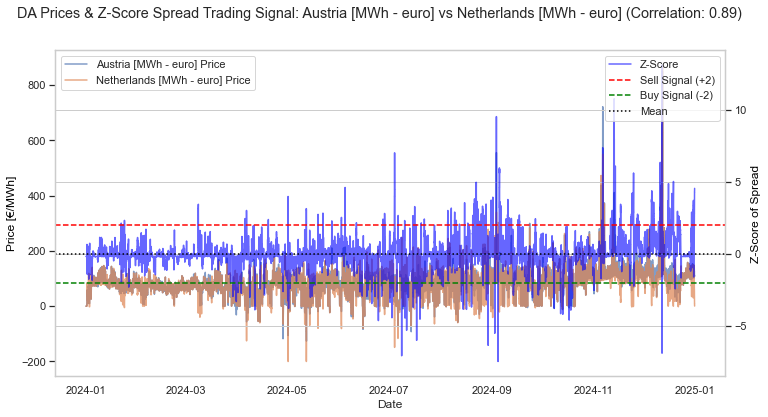

In [4]:
# ===========================================
# PART 4: CROSS-BORDER NET POWER FLOW ANALYSIS
# ===========================================

border_pairs = [
    ("Germany/Luxembourg [MWh - euro]", "Netherlands [MWh - euro]", "Netherlands (export) [MWh]", "Netherlands (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "France [MWh - euro]", "France (export) [MWh]", "France (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Poland [MWh - euro]", "Poland (export) [MWh]", "Poland (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Switzerland [MWh - euro]", "Switzerland (export) [MWh]", "Switzerland (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Denmark 1 [MWh - euro]", "Denmark (export) [MWh]", "Denmark (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Belgium [MWh - euro]", "Belgium (export) [MWh]", "Belgium (import) [MWh]")
]

correlation_results = []
plt.figure(figsize=(12, 6))

for base, target, export_col, import_col in border_pairs:
    if all(col in df.columns for col in [base, target, export_col, import_col]):
        df["Price Spread"] = df[target] - df[base]
        df["Net Flow"] = df[export_col] - df[import_col]
        df_filtered = df.dropna(subset=["Price Spread", "Net Flow"])
        df_filtered = df_filtered[df_filtered["Price Spread"] != 0]
        plt.scatter(df_filtered["Price Spread"], df_filtered["Net Flow"], alpha=0.5, label=f"{base} ↔ {target}")
        corr = df_filtered[["Price Spread", "Net Flow"]].corr().iloc[0, 1]
        correlation_results.append({"Border": f"{base} ↔ {target}", "Correlation": corr})

plt.axhline(0, color="black", linestyle="dashed", linewidth=1)
plt.axvline(0, color="black", linestyle="dashed", linewidth=1)
plt.xlabel("Price Spread [€/MWh]")
plt.ylabel("Net Power Flow [MWh] (Export - Import)")
plt.title("Cross-Border Net Power Flow vs. Price Differences")
plt.legend()
plt.grid()
plt.show()

correlation_df = pd.DataFrame(correlation_results)

# ===========================================
# PART 5: CORRELATION MATRIX OF DA PRICES
# ===========================================

da_price_columns = [col for col in df.columns if '[MWh - euro]' in col]
da_price_columns_clean = [col.replace(' [MWh - euro]', '') for col in da_price_columns]
da_prices = df[da_price_columns].copy()

corr_matrix = da_prices.corr()
corr_matrix_values = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
sorted_corr = corr_matrix_values.unstack().dropna().sort_values(ascending=False)
top_10_pairs_dict = dict(sorted_corr.head(10))
top10_df = pd.DataFrame([{"Country 1": k[0], "Country 2": k[1], "Correlation": v} for k, v in top_10_pairs_dict.items()])
print("\nTop 10 Most Correlated Country Pairs (DA Prices):")
print(top10_df)

for (country_1, country_2), correlation in top_10_pairs_dict.items():
    spread = df[country_1] - df[country_2]
    zscore = calculate_zscore(spread)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price [€/MWh]", color="black")
    ax1.plot(df['Start date'], df[country_1], label=f"{country_1} Price", alpha=0.7)
    ax1.plot(df['Start date'], df[country_2], label=f"{country_2} Price", alpha=0.7)
    ax1.legend(loc="upper left")
    ax1.grid()

    ax2 = ax1.twinx()
    ax2.set_ylabel("Z-Score of Spread", color="black")
    ax2.plot(df['Start date'], zscore, label="Z-Score", color="blue", alpha=0.6)
    ax2.axhline(2, color='red', linestyle='dashed', label="Sell Signal (+2)")
    ax2.axhline(-2, color='green', linestyle='dashed', label="Buy Signal (-2)")
    ax2.axhline(0, color='black', linestyle='dotted', label="Mean")

    fig.suptitle(f"DA Prices & Z-Score Spread Trading Signal: {country_1} vs {country_2} (Correlation: {correlation:.2f})")
    ax2.legend(loc="upper right")
    plt.show()


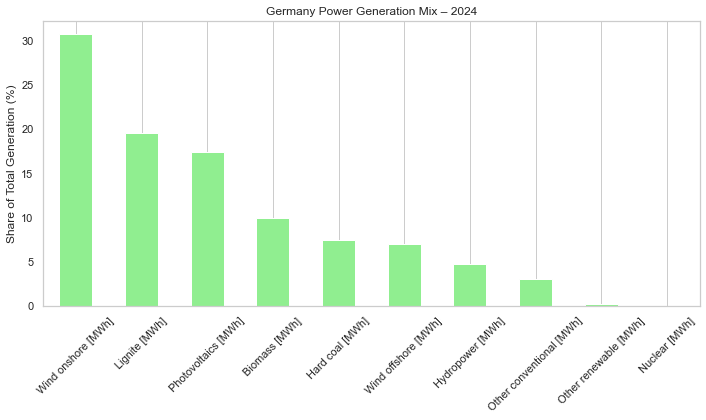

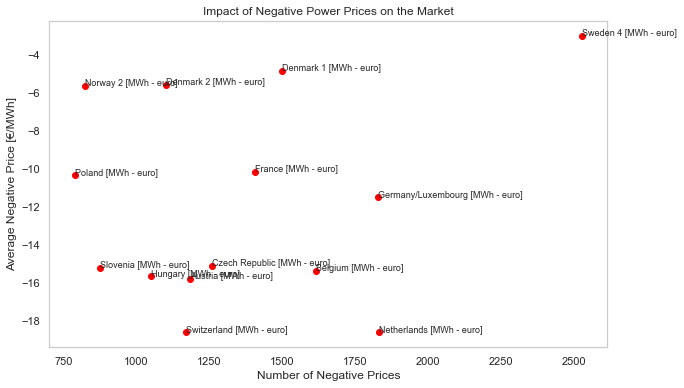

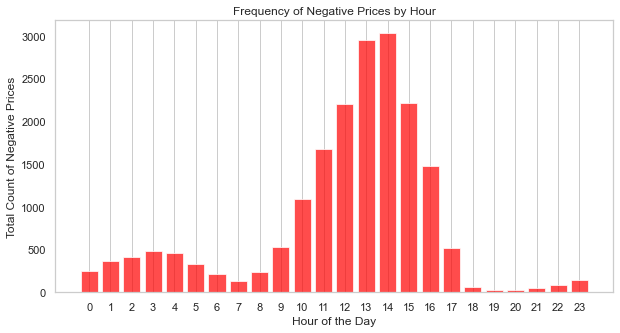

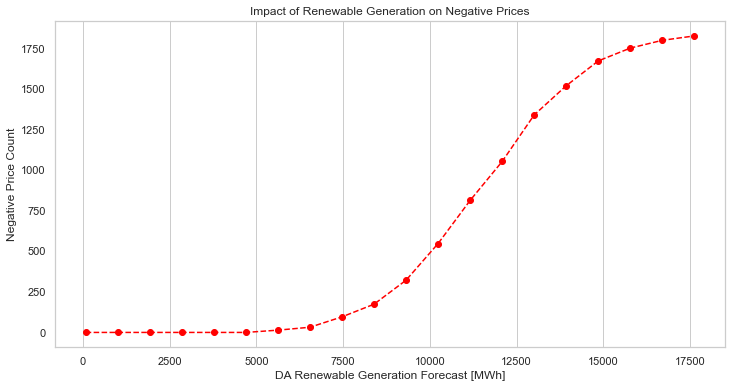

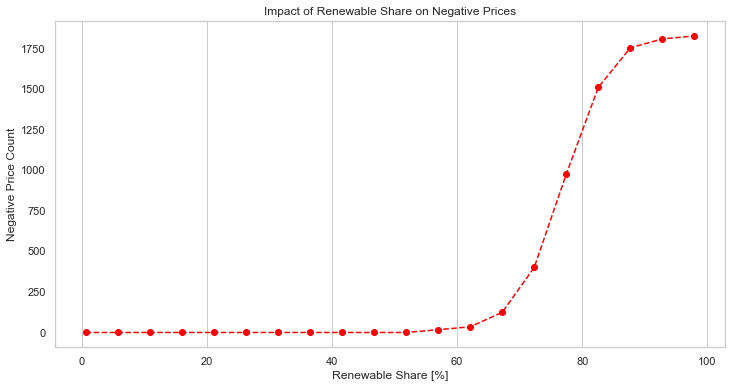

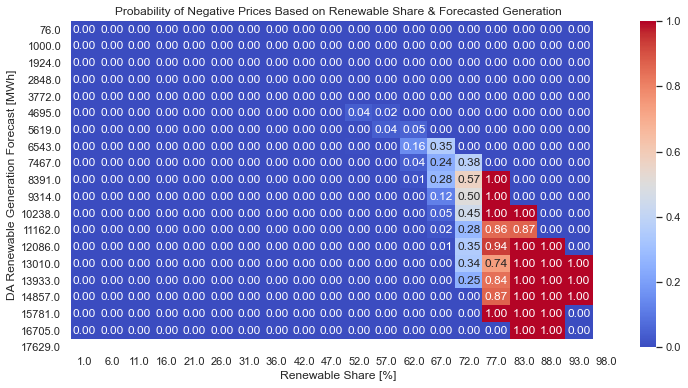

In [6]:
# ===========================================
# PART 6: NEGATIVE PRICE ANALYSIS
# ===========================================

# Parse datetime correctly
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce', format="%m/%d/%y %H:%M")

# Filter year 2024
df_2024 = df[df['Start date'].dt.year == 2024].copy()

# Define generation columns (keep only existing ones)
generation_cols = [
    "Biomass [MWh]", "Wind offshore [MWh]", "Wind onshore [MWh]",
    "Photovoltaics [MWh]", "Hydropower [MWh]", "Other renewable [MWh]",
    "Nuclear [MWh]", "Lignite [MWh]", "Hard coal [MWh]", "Other conventional [MWh]"
]
generation_cols = [col for col in generation_cols if col in df_2024.columns]

# Sort by time and set index
df_2024.sort_values("Start date", inplace=True)
df_2024.set_index("Start date", inplace=True)

# Convert to numeric + interpolate
for col in generation_cols:
    df_2024[col] = pd.to_numeric(df_2024[col], errors='coerce')
    df_2024[col] = df_2024[col].interpolate(method='time')

# Create date-only column
df_2024["date"] = pd.to_datetime(df_2024.index.date)

# ---------------------- Total annual generation per source ----------------------
total_gen = df_2024[generation_cols].sum()
percent_share = (total_gen / total_gen.sum() * 100).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
percent_share.plot(kind="bar", color="lightgreen")
plt.title("Germany Power Generation Mix – 2024")
plt.ylabel("Share of Total Generation (%)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ===========================================
# PART 7: RENEWABLE GENERATION IMPACT ON NEGATIVE PRICES
# ===========================================

df['Hour'] = df['Start date'].dt.hour

# Negative prices analysis
negative_prices = (da_prices < 0).sum()
avg_negative_prices = da_prices[da_prices < 0].mean()

negative_prices = negative_prices[negative_prices > 0]
avg_negative_prices = avg_negative_prices.dropna()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(negative_prices, avg_negative_prices, color='red')
plt.title("Impact of Negative Power Prices on the Market")
plt.xlabel("Number of Negative Prices")
plt.ylabel("Average Negative Price [€/MWh]")
for country in negative_prices.index:
    plt.annotate(country, (negative_prices[country], avg_negative_prices[country]), fontsize=9)
plt.grid()
plt.show()

# Bar plot: Negative prices by hour
neg_price_by_hour = (da_prices < 0).sum(axis=1).groupby(df['Hour']).sum()
plt.figure(figsize=(10, 5))
plt.bar(neg_price_by_hour.index, neg_price_by_hour, color="red", alpha=0.7)
plt.title("Frequency of Negative Prices by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Count of Negative Prices")
plt.grid(axis="y")
plt.xticks(range(0, 24))
plt.show()

# ===========================================
# PART 8: RENEWABLES IMPACT ON NEGATIVE PRICES (DEEPER)
# ===========================================

# Calculate Renewable Share
df["Renewable Share (%)"] = (
    df["DA Photovoltaics and wind [MWh] forecast"] /
    (df["DA Photovoltaics and wind [MWh] forecast"] + df["DA Other [MWh] forecast"])
) * 100

# Prepare thresholds
mw_thresholds = np.linspace(df["DA Photovoltaics and wind [MWh] forecast"].min(), df["DA Photovoltaics and wind [MWh] forecast"].max(), 20)
percent_thresholds = np.linspace(df["Renewable Share (%)"].min(), df["Renewable Share (%)"].max(), 20)

def count_neg_prices(df, column, thresholds):
    return [(df[df[column] <= t]["DE (MWh euro)"] < 0).sum() for t in thresholds]

neg_price_counts_mwh = count_neg_prices(df, "DA Photovoltaics and wind [MWh] forecast", mw_thresholds)
neg_price_counts_percent = count_neg_prices(df, "Renewable Share (%)", percent_thresholds)

# Plot MWh Threshold Impact
plt.figure(figsize=(12, 6))
plt.plot(mw_thresholds, neg_price_counts_mwh, marker='o', linestyle='dashed', color='red')
plt.title("Impact of Renewable Generation on Negative Prices")
plt.xlabel("DA Renewable Generation Forecast [MWh]")
plt.ylabel("Negative Price Count")
plt.grid(axis='y', linestyle='dashed')
plt.show()

# Plot Percent Threshold Impact
plt.figure(figsize=(12, 6))
plt.plot(percent_thresholds, neg_price_counts_percent, marker='o', linestyle='dashed', color='red')
plt.title("Impact of Renewable Share on Negative Prices")
plt.xlabel("Renewable Share [%]")
plt.ylabel("Negative Price Count")
plt.grid(axis='y', linestyle='dashed')
plt.show()

# Heatmap
bins_x = np.linspace(df["DA Photovoltaics and wind [MWh] forecast"].min(), df["DA Photovoltaics and wind [MWh] forecast"].max(), 20)
bins_y = np.linspace(df["Renewable Share (%)"].min(), df["Renewable Share (%)"].max(), 20)
heatmap_data = np.zeros((len(bins_x) - 1, len(bins_y) - 1))

for i in range(len(bins_x) - 1):
    for j in range(len(bins_y) - 1):
        subset = df[
            (df["DA Photovoltaics and wind [MWh] forecast"] >= bins_x[i]) & (df["DA Photovoltaics and wind [MWh] forecast"] < bins_x[i+1]) &
            (df["Renewable Share (%)"] >= bins_y[j]) & (df["Renewable Share (%)"] < bins_y[j+1])
        ]
        if len(subset) > 0:
            heatmap_data[i, j] = subset["DE (MWh euro)"].lt(0).mean()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f",
            xticklabels=np.round(bins_y, 0), yticklabels=np.round(bins_x, 0))
plt.xlabel("Renewable Share [%]")
plt.ylabel("DA Renewable Generation Forecast [MWh]")
plt.title("Probability of Negative Prices Based on Renewable Share & Forecasted Generation")
plt.show()



Epoch 1/50
902/902 [==============================] - 16s 13ms/step - loss: 6.0160e-04 - val_loss: 0.0014
Epoch 2/50
902/902 [==============================] - 12s 13ms/step - loss: 2.4429e-04 - val_loss: 6.1110e-04
Epoch 3/50
902/902 [==============================] - 9s 9ms/step - loss: 1.8663e-04 - val_loss: 4.2219e-04
Epoch 4/50
902/902 [==============================] - 6s 7ms/step - loss: 1.7989e-04 - val_loss: 4.9756e-04
Epoch 5/50
902/902 [==============================] - 7s 7ms/step - loss: 1.6587e-04 - val_loss: 4.3384e-04
Epoch 6/50
902/902 [==============================] - 7s 7ms/step - loss: 1.5656e-04 - val_loss: 4.2656e-04
Epoch 7/50
902/902 [==============================] - 7s 7ms/step - loss: 1.5351e-04 - val_loss: 4.3761e-04
Epoch 8/50
93/93 [==============================] - 1s 8ms/step

===== LSTM Forecast Evaluation =====
RMSE:  18.20 €/MWh
MAE:   9.96 €/MWh
MdAE:  6.65 €/MWh


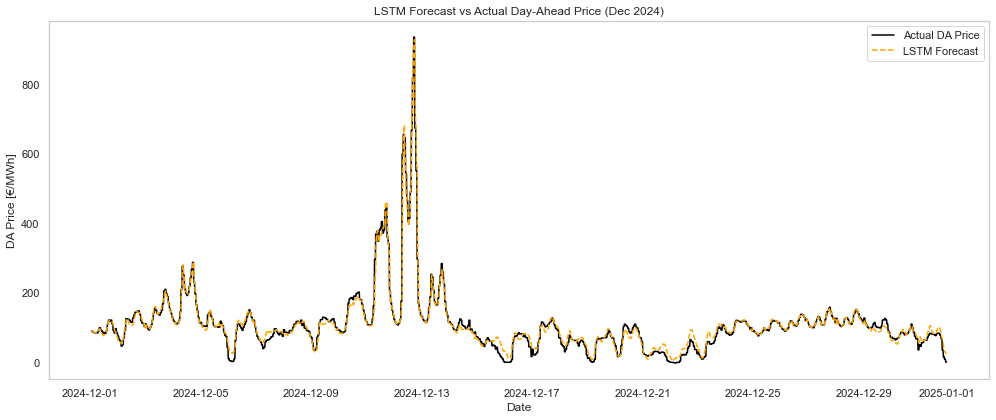

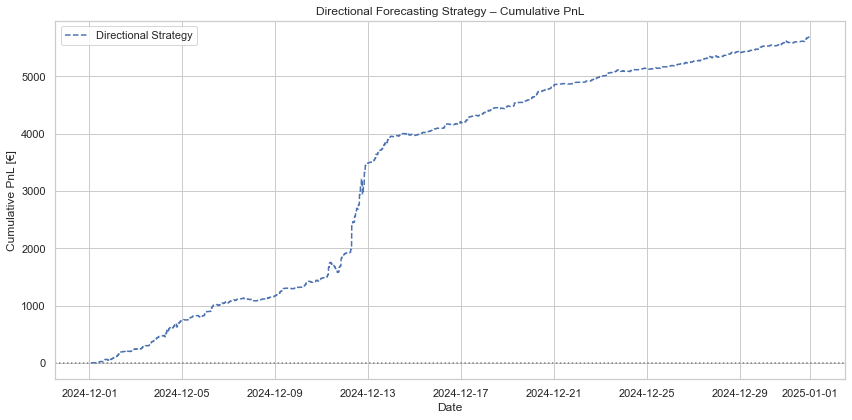

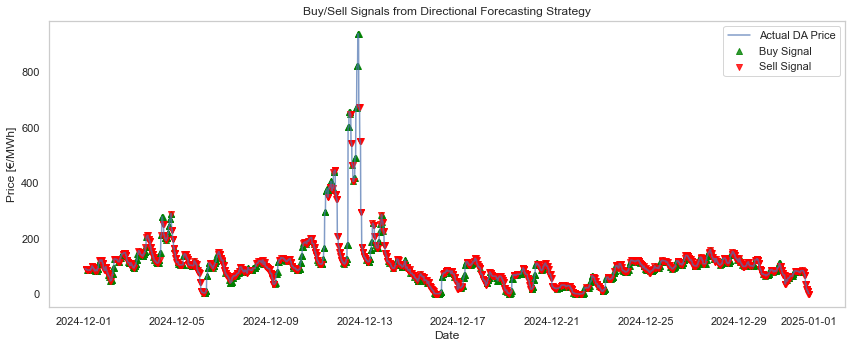


===== Directional Trading Strategy Summary =====
Final Cumulative PnL: €5683.23
Total Trades: 2969
Buy Signals: 1338
Sell Signals: 1631


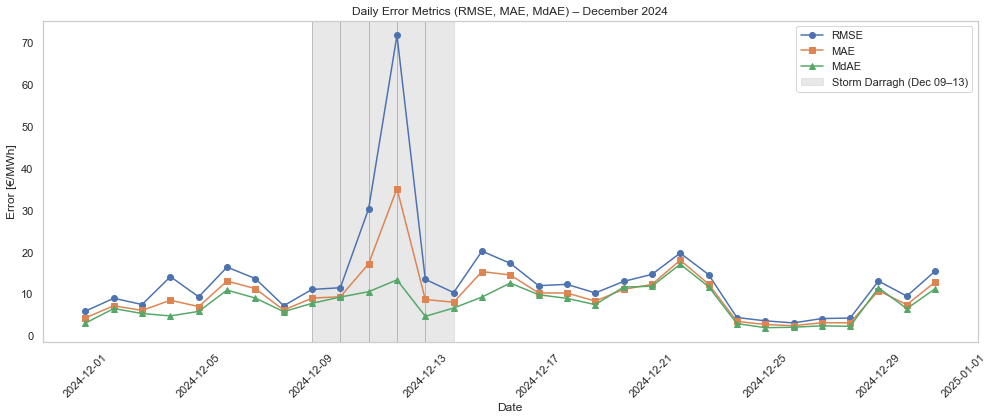


===== LSTM Forecast Evaluation (excluding Storm Darragh) =====
RMSE:  10.94 €/MWh
MAE:   8.82 €/MWh
MdAE:  7.63 €/MWh


In [19]:
# ===========================================
# PART 9: START LSTM FORECASTING SETUP
# ===========================================

# ---------------------- Load and Clean again ----------------------
df['DA Other [MWh] forecast'] = pd.to_numeric(df['DA Other [MWh] forecast'], errors='coerce')

# Define Features and Target for Forecasting
target_col = 'DE (MWh euro)'
features = [
    'grid load [MWh] forecasted', 'Residual load [MWh] forecasted',
    'DA Photovoltaics and wind [MWh] forecast', 'DA Wind onshore [MWh] forecast',
    'DA Wind offshore [MWh] forecast', 'DA Photovoltaics [MWh] forecast',
    'DA Other [MWh] forecast', 'ID Photovoltaics and wind [MWh] forecast',
    'ID Wind onshore [MWh] forecast', 'ID Wind offshore [MWh] forecast',
    'ID Photovoltaics [MWh] forecast',
    'France [MWh - euro]', 'Netherlands [MWh - euro]', 'Belgium [MWh - euro]', 'Poland [MWh - euro]', 
    'Sweden 4 [MWh - euro]', 'Denmark 1 [MWh - euro]', 'Denmark 2 [MWh - euro]', 'Switzerland [MWh - euro]',
    'Czech Republic [MWh - euro]', 'Austria [MWh - euro]'
]

df_model = df[['Start date', target_col] + features].dropna().sort_values('Start date')
train_df = df_model[df_model['Start date'] < '2024-12-01']
test_df = df_model[df_model['Start date'] >= '2024-12-01']

# ---------------------- Scaling ----------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_df[features])
test_X = scaler_X.transform(test_df[features])
train_y = scaler_y.fit_transform(train_df[[target_col]])
test_y = scaler_y.transform(test_df[[target_col]])

def reshape_for_lstm(X, y, window=6):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - window):
        X_lstm.append(X[i:i+window])
        y_lstm.append(y[i+window])
    return np.array(X_lstm), np.array(y_lstm)

window = 6
X_train_lstm, y_train_lstm = reshape_for_lstm(train_X, train_y, window)
X_test_lstm, y_test_lstm = reshape_for_lstm(test_X, test_y, window)

# ===========================================
# PART 10: BUILD AND TRAIN LSTM MODEL
# ===========================================

# ---------------------- Build LSTM Model ----------------------
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ---------------------- Train Model ----------------------
model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ===========================================
# PART 11: EVALUATE LSTM FORECASTING
# ===========================================

# ---------------------- Predictions ----------------------
preds_scaled = model.predict(X_test_lstm)
preds = scaler_y.inverse_transform(preds_scaled)
y_true = scaler_y.inverse_transform(y_test_lstm)

# ---------------------- Metrics ----------------------
rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
mdae = median_absolute_error(y_true, preds)

print("\n===== LSTM Forecast Evaluation =====")
print(f"RMSE:  {rmse:.2f} €/MWh")
print(f"MAE:   {mae:.2f} €/MWh")
print(f"MdAE:  {mdae:.2f} €/MWh")

# ---------------------- Create Forecast DataFrame ----------------------
forecast_dates = test_df['Start date'].iloc[window:].reset_index(drop=True)
forecast_df = pd.DataFrame({
    'Start date': forecast_dates,
    'Actual DA Price [euro/MWh]': y_true.flatten(),
    'Forecast DA Price [euro/MWh]': preds.flatten()
})

# Save Forecast
forecast_df.to_csv('/Users/gaetanledu/Documents/CASE/ENGIE/DE/LSTM_DA_forecast_vs_actual.csv', index=False)

# ---------------------- Plot Forecast vs Actual ----------------------
plt.figure(figsize=(14, 6))
plt.plot(forecast_df["Start date"], forecast_df["Actual DA Price [euro/MWh]"], label="Actual DA Price", color="black")
plt.plot(forecast_df["Start date"], forecast_df["Forecast DA Price [euro/MWh]"], label="LSTM Forecast", color="orange", linestyle="--")
plt.title("LSTM Forecast vs Actual Day-Ahead Price (Dec 2024)")
plt.xlabel("Date")
plt.ylabel("DA Price [€/MWh]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------------------- Compute Changes ----------------------
forecast_df["Forecast Change"] = forecast_df["Forecast DA Price [euro/MWh]"].diff()
forecast_df["Actual Change"] = forecast_df["Actual DA Price [euro/MWh]"].diff()

# ---------------------- Directional Signal ----------------------
forecast_df["Direction Signal"] = forecast_df["Forecast Change"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# ---------------------- Calculate PnL ----------------------
forecast_df["PnL"] = forecast_df["Direction Signal"].shift(1) * forecast_df["Actual Change"]
forecast_df["Cumulative PnL"] = forecast_df["PnL"].cumsum()

# ---------------------- Plot Cumulative PnL ----------------------
plt.figure(figsize=(12, 6))
plt.plot(forecast_df["Start date"], forecast_df["Cumulative PnL"], label="Directional Strategy", linestyle="--")
plt.axhline(0, color='gray', linestyle=':')
plt.title("Directional Forecasting Strategy – Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL [€]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------- Plot Buy/Sell Signals ----------------------
plt.figure(figsize=(12, 5))
plt.plot(forecast_df["Start date"], forecast_df["Actual DA Price [euro/MWh]"], label="Actual DA Price", alpha=0.7)

buy_signals = forecast_df[forecast_df["Direction Signal"] == 1]
sell_signals = forecast_df[forecast_df["Direction Signal"] == -1]

plt.scatter(buy_signals["Start date"], buy_signals["Actual DA Price [euro/MWh]"],
            color='green', marker='^', label='Buy Signal', alpha=0.8)
plt.scatter(sell_signals["Start date"], sell_signals["Actual DA Price [euro/MWh]"],
            color='red', marker='v', label='Sell Signal', alpha=0.8)

plt.title("Buy/Sell Signals from Directional Forecasting Strategy")
plt.xlabel("Date")
plt.ylabel("Price [€/MWh]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------------------- Strategy Summary ----------------------
total_trades = (forecast_df["Direction Signal"] != 0).sum()
buy_trades = (forecast_df["Direction Signal"] == 1).sum()
sell_trades = (forecast_df["Direction Signal"] == -1).sum()
final_pnl = forecast_df["Cumulative PnL"].iloc[-1]

print(f"\n===== Directional Trading Strategy Summary =====")
print(f"Final Cumulative PnL: €{final_pnl:.2f}")
print(f"Total Trades: {total_trades}")
print(f"Buy Signals: {buy_trades}")
print(f"Sell Signals: {sell_trades}")

# ===========================================
# PART 12: STORM IMPACT ON FORECASTING 
# ===========================================

# ---------------------- 1. Plot: RMSE, MAE, MdAE Evolution + Storm Highlight ----------------------
forecast_df["Date_only"] = forecast_df["Start date"].dt.date

daily_metrics = forecast_df.groupby("Date_only").apply(
    lambda x: pd.Series({
        "RMSE": np.sqrt(mean_squared_error(x["Actual DA Price [euro/MWh]"], x["Forecast DA Price [euro/MWh]"])),
        "MAE": mean_absolute_error(x["Actual DA Price [euro/MWh]"], x["Forecast DA Price [euro/MWh]"]),
        "MdAE": median_absolute_error(x["Actual DA Price [euro/MWh]"], x["Forecast DA Price [euro/MWh]"])
    })
).reset_index()

# Highlight Storm Darragh
storm_days = pd.date_range("2024-12-09", "2024-12-13").date

plt.figure(figsize=(14, 6))
plt.plot(daily_metrics["Date_only"], daily_metrics["RMSE"], label="RMSE", marker='o')
plt.plot(daily_metrics["Date_only"], daily_metrics["MAE"], label="MAE", marker='s')
plt.plot(daily_metrics["Date_only"], daily_metrics["MdAE"], label="MdAE", marker='^')

# Highlight storm period
for day in storm_days:
    plt.axvspan(day, day, color='grey', alpha=0.8)
plt.axvspan(pd.to_datetime("2024-12-09"), pd.to_datetime("2024-12-14"), color='lightgrey', alpha=0.5, label="Storm Darragh (Dec 09–13)")


plt.title("Daily Error Metrics (RMSE, MAE, MdAE) – December 2024")
plt.xlabel("Date")
plt.ylabel("Error [€/MWh]")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------------------- 2. Print Mean Error Metrics (Excl. Storm) ----------------------
clean_metrics = daily_metrics[~daily_metrics["Date_only"].isin(storm_days)]

rmse_clean = clean_metrics["RMSE"].mean()
mae_clean = clean_metrics["MAE"].mean()
mdae_clean = clean_metrics["MdAE"].mean()

print("\n===== LSTM Forecast Evaluation (excluding Storm Darragh) =====")
print(f"RMSE:  {rmse_clean:.2f} €/MWh")
print(f"MAE:   {mae_clean:.2f} €/MWh")
print(f"MdAE:  {mdae_clean:.2f} €/MWh")

[LightGBM] [Info] Number of positive: 1462, number of negative: 26570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 28032, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052155 -> initscore=-2.899977
[LightGBM] [Info] Start training from score -2.899977

===== LightGBM Classification Report =====

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6642
           1       0.93      0.88      0.90       366

    accuracy                           0.99      7008
   macro avg       0.96      0.94      0.95      7008
weighted avg       0.99      0.99      0.99      7008



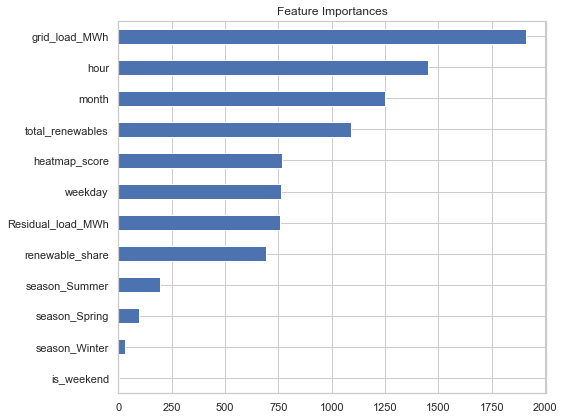

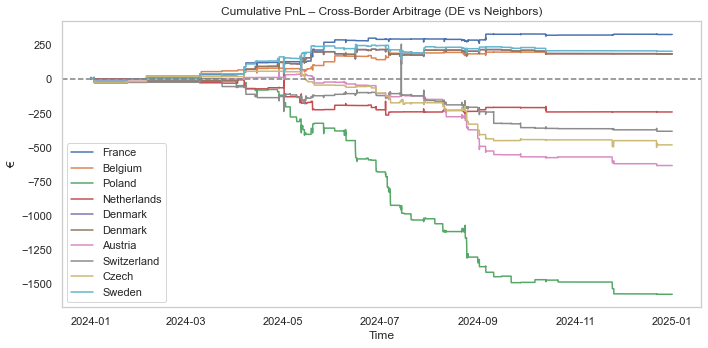


===== Scaled PnL Estimates (Cross-Border Strategy) =====

                   neighbor  scaled_pnl (€)  flow (MWh/15min)  total_trades
        France [MWh - euro]       163090.00               500          1351
       Belgium [MWh - euro]        69330.00               375          1351
     Denmark 1 [MWh - euro]        48322.00               200          1351
     Denmark 2 [MWh - euro]        36612.00               200          1351
      Sweden 4 [MWh - euro]        15260.25                75          1351
Czech Republic [MWh - euro]      -120910.00               250          1351
   Netherlands [MWh - euro]      -151393.75               625          1351
   Switzerland [MWh - euro]      -172665.00               450          1351
        Poland [MWh - euro]      -394895.00               250          1351
       Austria [MWh - euro]      -476280.00               750          1351

===== Optimized Cross-Border Strategy Results =====

 threshold    neighbor  scaled_pnl (€)  flow (MWh/1

In [17]:
# ===========================================
# PART 13: START CROSS-BORDER ARBITRAGE STRATEGY (Negative DA Price Focus)
# ===========================================

# ---------------------- Reload Data for Fresh Start ----------------------
df = pd.read_csv(ALL_PATH)
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')

# Normalize columns
df.columns = df.columns.str.encode('ascii', 'ignore').str.decode('ascii')
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()
df["Start date"] = pd.to_datetime(df["Start date"], format="%m/%d/%y %H:%M")

# Time features
df["hour"] = df["Start date"].dt.hour
df["weekday"] = df["Start date"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["month"] = df["Start date"].dt.month

# Add seasonal dummies
df["season"] = df["Start date"].apply(get_season)
df = pd.get_dummies(df, columns=["season"], drop_first=True)

# Target: negative prices
df["is_negative_price"] = (df["DE (MWh euro)"] < 0).astype(int)

# Renewables related features
df["total_renewables"] = df[[
    "Wind onshore [MWh]", "Wind offshore [MWh]", "Photovoltaics [MWh]",
    "Biomass [MWh]", "Hydropower [MWh]", "Other renewable [MWh]"
]].sum(axis=1)
df["renewable_share"] = df["total_renewables"] / df["grid load [MWh]"]

# Heatmap logic for forecast scores
forecast_cols = [
    "DA Wind onshore [MWh] forecast", "DA Wind offshore [MWh] forecast",
    "DA Photovoltaics [MWh] forecast", "DA Other [MWh] forecast"
]
df[forecast_cols] = df[forecast_cols].apply(pd.to_numeric, errors='coerce')
df["DA_renewable_forecast"] = df[forecast_cols].sum(axis=1)
df["renewable_share_bin"] = (df["renewable_share"] * 100).round().clip(1, 100)
df["DA_renewable_forecast_bin"] = (df["DA_renewable_forecast"] // 1000 * 1000).clip(500, 18000)

heatmap_data = df.pivot_table(
    index="DA_renewable_forecast_bin",
    columns="renewable_share_bin",
    values="is_negative_price",
    aggfunc="mean"
).fillna(0)

df["heatmap_score"] = df.apply(
    lambda row: heatmap_data.loc[row["DA_renewable_forecast_bin"], row["renewable_share_bin"]]
    if row["DA_renewable_forecast_bin"] in heatmap_data.index and row["renewable_share_bin"] in heatmap_data.columns else 0.0,
    axis=1
)

# ===========================================
# PART 14: TRAIN LIGHTGBM MODEL TO PREDICT NEGATIVE DA PRICES
# ===========================================

# ---------------------- Final Clean ----------------------
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Feature list for LightGBM
features = [
    "hour", "weekday", "is_weekend", "month", "total_renewables", "renewable_share",
    "Residual load [MWh]", "grid load [MWh]",
    "season_Spring", "season_Summer", "season_Winter", "heatmap_score"
]
X = df[features].copy()
X.columns = X.columns.str.replace(r"[\[\]<>]", "", regex=True).str.replace(" ", "_")
y = df["is_negative_price"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Build LightGBM model
model = LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Evaluation
print("\n===== LightGBM Classification Report =====\n")
print(classification_report(y_test, model.predict(X_test)))

# Plot feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(8, 6), title="Feature Importances")
plt.tight_layout()
plt.show()

# ===========================================
# PART 15: CROSS-BORDER ARBITRAGE STRATEGY SIMULATION
# ===========================================

# ---------------------- Prediction ----------------------
df["pred_prob"] = model.predict_proba(X)[:, 1]
df["pred_signal"] = (df["pred_prob"] > 0.9).astype(int)

# Neighboring markets
neighbors = [
    "France [MWh - euro]", "Belgium [MWh - euro]", "Poland [MWh - euro]",
    "Netherlands [MWh - euro]", "Denmark 1 [MWh - euro]", "Denmark 2 [MWh - euro]",
    "Austria [MWh - euro]", "Switzerland [MWh - euro]", "Czech Republic [MWh - euro]",
    "Sweden 4 [MWh - euro]"
]

flows = {
    "France": 500, "Belgium": 375, "Poland": 250, "Netherlands": 625,
    "Denmark": 200, "Austria": 750, "Switzerland": 450, "Czech": 250, "Sweden": 75
}

# ---------------------- PnL Computation ----------------------
pnl_df = []
for neighbor in neighbors:
    label = neighbor.split()[0]
    df[f"Spread_{label}"] = df["DE (MWh euro)"] - df[neighbor]
    df[f"PnL_{label}"] = df["pred_signal"].shift(1) * df[f"Spread_{label}"].diff()
    df[f"Cumulative_{label}"] = df[f"PnL_{label}"].cumsum()
    flow = flows.get(label, 250)
    df[f"ScaledPnL_{label}"] = df[f"PnL_{label}"] * flow
    pnl_df.append({
        "neighbor": neighbor,
        "scaled_pnl (€)": df[f"ScaledPnL_{label}"].sum().round(2),
        "flow (MWh/15min)": flow,
        "total_trades": int(df["pred_signal"].sum())
    })

# ---------------------- Plot Cumulative PnL ----------------------
plt.figure(figsize=(10, 5))
for neighbor in neighbors:
    label = neighbor.split()[0]
    plt.plot(df["Start date"], df[f"Cumulative_{label}"], label=label)

plt.axhline(0, color="gray", linestyle="--")
plt.title("Cumulative PnL – Cross-Border Arbitrage (DE vs Neighbors)")
plt.ylabel("€")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------------------- Show Scaled PnL Summary ----------------------
pnl_summary = pd.DataFrame(pnl_df).sort_values(by="scaled_pnl (€)", ascending=False)
print("\n===== Scaled PnL Estimates (Cross-Border Strategy) =====\n")
print(pnl_summary.to_string(index=False))

# ===========================================
# PART 16: THRESHOLD OPTIMIZATION FOR CROSS-BORDER STRATEGY
# ===========================================

results = []

for threshold in [0.7, 0.8, 0.9, 0.95]:
    df["signal"] = (df["pred_prob"] > threshold).astype(int)
    total_trades = df["signal"].sum()
    trades_per_day = round(total_trades / df["Start date"].dt.date.nunique(), 2)
    
    for neighbor in neighbors:
        label = neighbor.split()[0]
        spread = df[f"Spread_{label}"]
        df[f"filtered_signal_{label}"] = df["signal"] * (spread.abs() > 5)
        
        flow = flows.get(label, 250)
        df[f"PnL_prob_weighted_{label}_{threshold}"] = (
            df[f"filtered_signal_{label}"].shift(1) * spread.diff() * flow * df["pred_prob"]
        )
        
        results.append({
            "threshold": threshold,
            "neighbor": label,
            "scaled_pnl (€)": df[f"PnL_prob_weighted_{label}_{threshold}"].sum().round(2),
            "flow (MWh/15min)": flow,
            "total_trades": int(total_trades),
            "trades/day": trades_per_day
        })

opt_df = pd.DataFrame(results).sort_values(by="scaled_pnl (€)", ascending=False)

print("\n===== Optimized Cross-Border Strategy Results =====\n")
print(opt_df.to_string(index=False))

# ===========================================
# PART 17: SUMMARY COMMENTS ABOUT STRATEGY LOGIC
# ===========================================

print("\n===== Strategy Logic Summary =====\n")
print("""
Cross-Border Arbitrage Strategy:
---------------------------------
1. Predict if Germany DA price will be negative using LightGBM classifier.
2. If probability > threshold (e.g., 0.9):
   - SHORT Germany (DE).
   - BUY from neighbor countries with higher expected DA prices.
3. Profit = Spread (neighbor - Germany) × energy traded.
4. Optimization:
   - Test different probability thresholds (0.7, 0.8, 0.9, 0.95).
   - Only execute trades when spread absolute value > €5 (to avoid noise).
   - Scale profits based on 15-min flow assumptions (MWh per interval).
   
Notes:
------
- Negative price days are highly profitable for cross-border trading.
- The model (LightGBM) predicts binary classification: 'negative price' or 'not'.
- Does not directly predict price level (use LSTM model separately for full regression forecast).
""")


[LightGBM] [Info] Number of positive: 7608, number of negative: 20347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 27955, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.272152 -> initscore=-0.983733
[LightGBM] [Info] Start training from score -0.983733

===== DA–CID Spread Prediction (LightGBM) =====

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5087
           1       0.82      0.74      0.78      1902

    accuracy                           0.89      6989
   macro avg       0.87      0.84      0.85      6989
weighted avg       0.88      0.89      0.88      6989



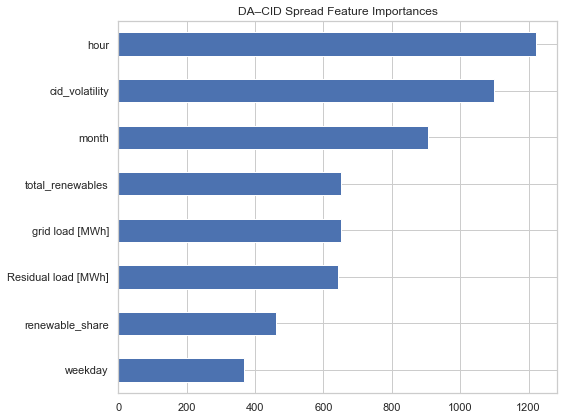

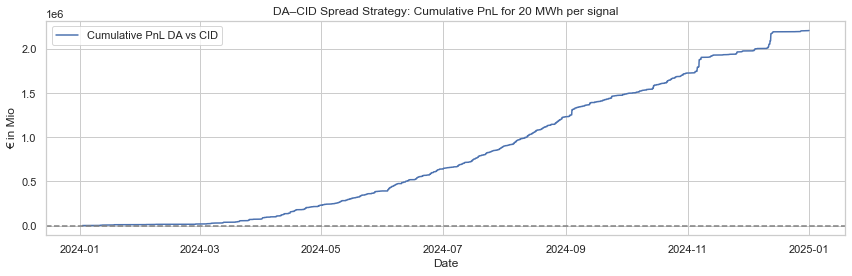

The total cumulative PnL for this strategy for 2024 is €2,208,056.60


In [14]:
# ===========================================
# PART 18: DA–CID SPREAD PREDICTION STRATEGY
# ===========================================

# Parameters
FLOW = 20  # MWh per trade

# Ensure datetime is correct
df["Start date"] = pd.to_datetime(df["Start date"], errors="coerce")

# Create DA–CID Spread
df["spread_DA_CID"] = df["DE (MWh euro)"] - df["DE CID (MWh euro)"]

# Calculate rolling CID volatility
df["cid_volatility"] = df["DE CID (MWh euro)"].rolling(window=96).std()

# Target: predict large positive spreads (>10 €/MWh)
df["target"] = (df["spread_DA_CID"] > 10).astype(int)

# Time features
df["hour"] = df["Start date"].dt.hour
df["weekday"] = df["Start date"].dt.weekday
df["month"] = df["Start date"].dt.month

# Drop NaNs
df = df.dropna(subset=["cid_volatility", "target"])

# Feature selection
features = [
    "hour", "weekday", "month", "Residual load [MWh]", "grid load [MWh]",
    "total_renewables", "renewable_share", "cid_volatility"
]

# Prepare data
df[features] = df[features].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=features)
X = df[features]
y = df["target"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Clean column names
X_train.columns = X_train.columns.str.replace(r"[^\w]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[^\w]", "_", regex=True)

# Train LightGBM
model_cid = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
model_cid.fit(X_train, y_train)

# Evaluate
print("\n===== DA–CID Spread Prediction (LightGBM) =====\n")
print(classification_report(y_test, model_cid.predict(X_test)))

# Feature Importance
importances_cid = pd.Series(model_cid.feature_importances_, index=X.columns)
importances_cid.sort_values().plot(kind="barh", figsize=(8, 6), title="DA–CID Spread Feature Importances")
plt.tight_layout()
plt.show()

# Predictions and Strategy
df["pred_prob_cid"] = model_cid.predict_proba(X)[:, 1]
df["signal_cid"] = (df["pred_prob_cid"] > 0.8).astype(int)

# PnL calculation
df["PnL_CID"] = df["signal_cid"].shift(1) * df["spread_DA_CID"] * FLOW
df["Cumulative PnL DA vs CID"] = df["PnL_CID"].cumsum()

# Plot
plt.figure(figsize=(12, 4))
plt.plot(df["Start date"], df["Cumulative PnL DA vs CID"], label="Cumulative PnL DA vs CID")
plt.axhline(0, color="gray", linestyle="--")
plt.title(f"DA–CID Spread Strategy: Cumulative PnL for {FLOW} MWh per signal")
plt.ylabel("€ in Mio")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print(f"The total cumulative PnL for this strategy for 2024 is €{df['Cumulative PnL DA vs CID'].iloc[-1]:,.2f}")




========= Battery Optimizer - Model Features & Assumptions =========
1. Simulation Period: Full year 2024 (Jan 1 - Dec 31)
2. Battery Parameters:
   - Capacity: 100 MWh
   - Max Power: 50 MW (charge/discharge)
   - Charging Efficiency: 95.0%
   - Discharging Efficiency: 95.0%
3. Trading Constraints:
   - Max Cycles per Day: 2 full cycles
   - Max Storage Hold Time: 120 minutes (2 hours)
   - Profit Spread Threshold: 5 €/MWh minimum to trigger trade
   - Trading Fee: 0.75 €/MWh (buy and sell)
4. Optimization Strategy:
   - Dynamic Early Exits: Battery discharges early if near-future price is almost as good as best future.
   - No Imbalance Costs: Assumes perfect execution on DA auction volumes.
   - No Partial Fills: Assume 50MW charge/discharge possible every 15 minutes without liquidity issues.
5. Degradation Costs:
   - Cycling OPEX: 5€/MWh charged (battery aging and maintenance impact)
6. Risk Management:
   - Minimized Forced Discharges: Early exits before storage expiration (2h) 

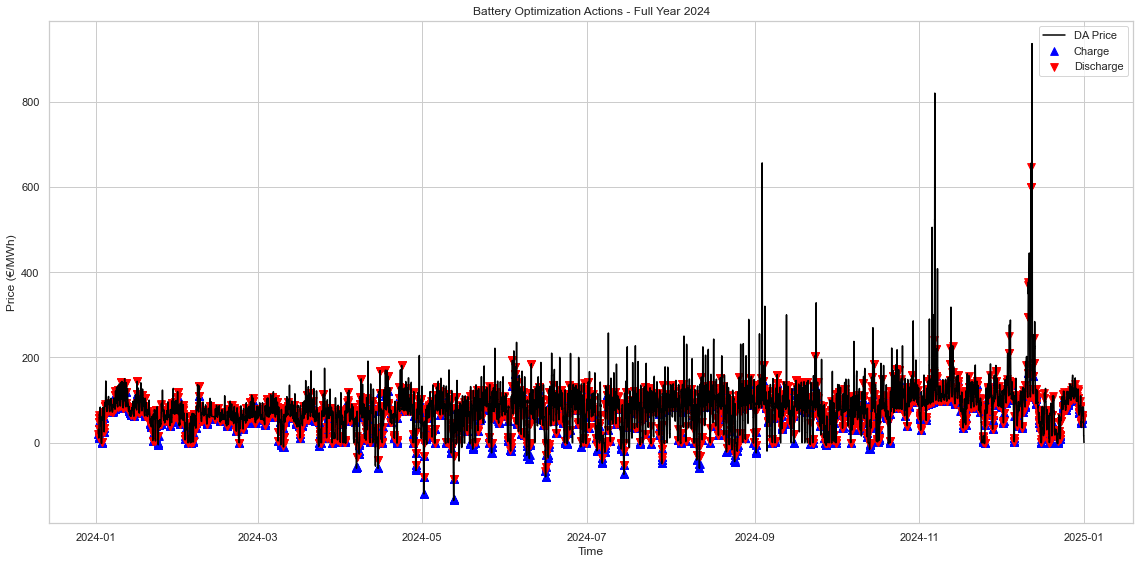

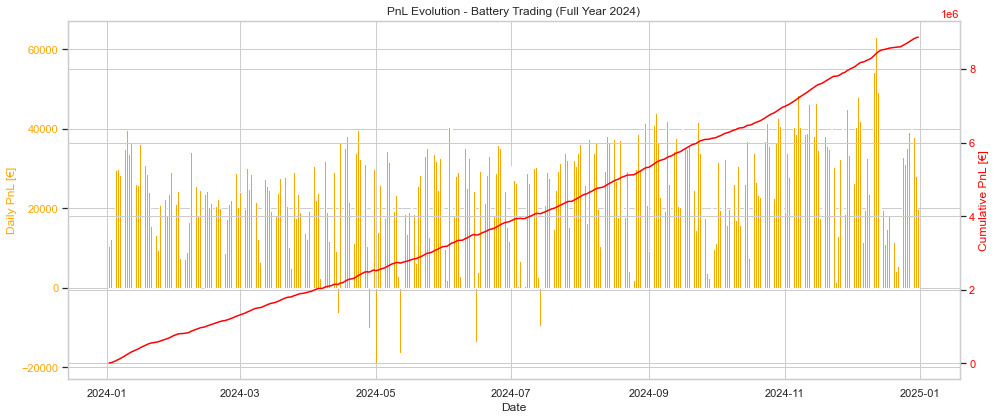


========= Final Summary =========
Total cumulative PnL: €8,867,678.47
Average Daily PnL: €24,361.75
Forced Discharge Total: 2742.53 MWh
Normal Discharge Total: 0.00 MWh
Early Discharge Total: 62643.24 MWh
Normal discharges = planned perfect spreads. Early discharges = smart risk-managed exits. Forced discharges = emergency dumps.


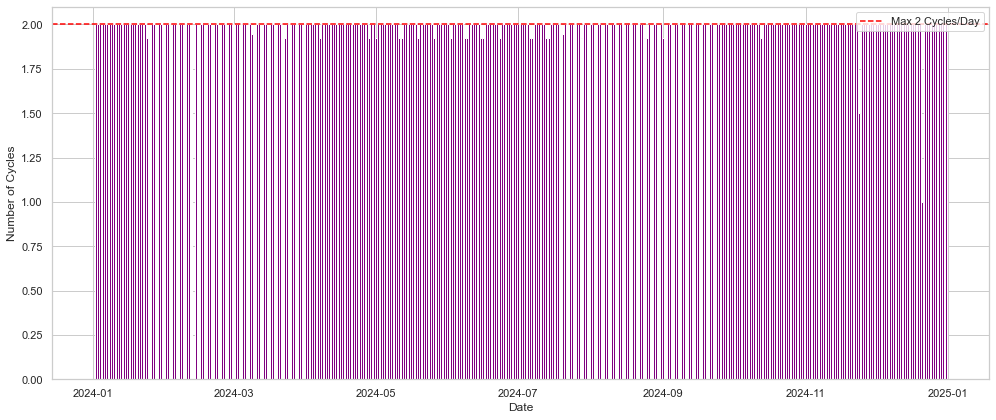

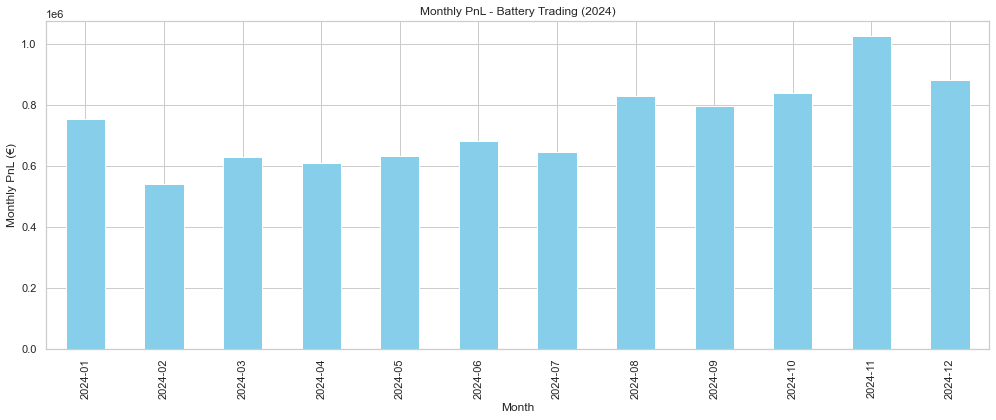


========= Realized Spread Summary =========
Average Buy Price: 60.43 €/MWh
Average Sell Price: 73.30 €/MWh
Realized Spread: 12.86 €/MWh

========= Degradation Cost Impact =========
Total Degradation Cost: €344,135.68 -- assume €5 per MWh cycled for OPEX / degradation.
Net PnL after Degradation: €8,523,542.79


In [16]:
# ===========================================
# PART 19: SMART BATTERY OPTIMIZER SETUP (BESS)
# ===========================================

if not pd.api.types.is_datetime64_any_dtype(df['Start date']):
    df['Start date'] = pd.to_datetime(df['Start date'])

df_year = df[(df['Start date'] >= '2024-01-01') & (df['Start date'] < '2025-01-01')].copy()

df_year['Quarter'] = df_year['Start date'].dt.hour * 4 + (df_year['Start date'].dt.minute // 15)
df_year['Date'] = df_year['Start date'].dt.date

da_curves = df_year.groupby('Date').apply(lambda x: x.set_index('Quarter')['DE (MWh euro)'].to_dict())

# --- 2. Battery and Trading Parameters ---
params = {
    'battery_capacity_mwh': 100,               # Total energy capacity
    'battery_power_mw': 50,                    # Max charge/discharge power
    'charging_efficiency': 0.95,               # Charging efficiency
    'discharging_efficiency': 0.95,             # Discharging efficiency
    'time_step_hours': 0.25,                   # 15 minutes
    'max_storage_duration_qh': 8,              # 2 hours max storage
    'profit_spread_threshold': 5,              # Minimum spread to enter trades
    'max_cycles_per_day': 2,                   # Max 2 full cycles per day
    'trading_fee_eur_per_mwh': 0.75             # Trading fee per MWh traded
}

# --- 3. Simulation Engine ---
results = []
charge_actions = []
discharge_actions = []

storage_units = []  # Each unit: {energy, age_qh}
storage_level = 0

sorted_dates = sorted(da_curves.index)

for today_date in sorted_dates:
    da_prices = da_curves[today_date]
    pnl_today = 0
    charged_today = 0.0
    discharged_today = 0.0

    for q in range(96):
        price_now = da_prices.get(q, np.nan)
        if np.isnan(price_now):
            continue

        today_datetime = datetime.combine(today_date, time(hour=q//4, minute=(q%4)*15))

        # Update unit aging
        for unit in storage_units:
            unit['age_qh'] += 1

        # Early exit logic: discharge if price_now is good enough
        if storage_level > 0:
            future_prices = [da_prices.get(qq, np.nan) for qq in range(q+1, q+2)]
            future_prices = [p for p in future_prices if not np.isnan(p)]

            if future_prices:
                next_15min_price = future_prices[0]

                # Early discharge condition
                if price_now >= 0.90 * next_15min_price:
                    available_energy = storage_level
                    discharge_energy = min(available_energy, params['battery_power_mw'] * params['time_step_hours'])
                    effective_energy = discharge_energy * params['discharging_efficiency']

                    pnl_today += effective_energy * (price_now - params['trading_fee_eur_per_mwh'])
                    storage_level -= discharge_energy
                    discharged_today += discharge_energy

                    discharge_actions.append((today_datetime, effective_energy, price_now, 'early'))

                    for unit in storage_units:
                        take = min(discharge_energy, unit['energy'])
                        unit['energy'] -= take
                        discharge_energy -= take
                        if discharge_energy <= 0:
                            break
                    storage_units = [u for u in storage_units if u['energy'] > 0]

        # Forced discharge if storage exceeds max hold duration
        forced_units = [u for u in storage_units if u['age_qh'] > params['max_storage_duration_qh']]
        for unit in forced_units:
            discharge_energy = unit['energy']
            effective_energy = discharge_energy * params['discharging_efficiency']
            pnl_today += effective_energy * (price_now - params['trading_fee_eur_per_mwh'])
            discharge_actions.append((today_datetime, effective_energy, price_now, 'forced'))
            storage_level -= discharge_energy
            discharged_today += discharge_energy
            unit['energy'] = 0

        storage_units = [u for u in storage_units if u['energy'] > 0]

        # Entry decision: Charging
        future_prices = [da_prices.get(qq, np.nan) for qq in range(q+1, min(q+params['max_storage_duration_qh']+1, 96))]
        future_prices = [p for p in future_prices if not np.isnan(p)]

        if not future_prices:
            continue

        best_future_price = max(future_prices)
        worst_future_price = min(future_prices)

        max_energy_step = params['battery_power_mw'] * params['time_step_hours']

        if (best_future_price - price_now) >= params['profit_spread_threshold'] and storage_level < params['battery_capacity_mwh']:
            available_storage = params['battery_capacity_mwh'] - storage_level
            charge_energy = min(available_storage, max_energy_step)

            effective_energy = charge_energy * params['charging_efficiency']

            if (charged_today + charge_energy) / params['battery_capacity_mwh'] <= params['max_cycles_per_day']:
                pnl_today -= charge_energy * (price_now + params['trading_fee_eur_per_mwh'])
                storage_units.append({'energy': effective_energy, 'age_qh': 0})
                storage_level += effective_energy
                charged_today += charge_energy
                charge_actions.append((today_datetime, effective_energy, price_now, 'normal'))

    results.append({
        'Date': today_date,
        'Daily PnL (€)': pnl_today,
        'End Storage Level (MWh)': storage_level,
        'Daily Charged (MWh)': charged_today,
        'Daily Discharged (MWh)': discharged_today
    })

# --- 4. Results and Plots ---

# BESS details (Features and Assumptions): 
print("\n========= Battery Optimizer - Model Features & Assumptions =========")
print("1. Simulation Period: Full year 2024 (Jan 1 - Dec 31)")
print("2. Battery Parameters:")
print(f"   - Capacity: {params['battery_capacity_mwh']} MWh")
print(f"   - Max Power: {params['battery_power_mw']} MW (charge/discharge)")
print(f"   - Charging Efficiency: {params['charging_efficiency']*100:.1f}%")
print(f"   - Discharging Efficiency: {params['discharging_efficiency']*100:.1f}%")
print("3. Trading Constraints:")
print(f"   - Max Cycles per Day: {params['max_cycles_per_day']} full cycles")
print(f"   - Max Storage Hold Time: {params['max_storage_duration_qh']*15} minutes (2 hours)")
print(f"   - Profit Spread Threshold: {params['profit_spread_threshold']} €/MWh minimum to trigger trade")
print(f"   - Trading Fee: {params['trading_fee_eur_per_mwh']} €/MWh (buy and sell)")
print("4. Optimization Strategy:")
print("   - Dynamic Early Exits: Battery discharges early if near-future price is almost as good as best future.")
print("   - No Imbalance Costs: Assumes perfect execution on DA auction volumes.")
print("   - No Partial Fills: Assume 50MW charge/discharge possible every 15 minutes without liquidity issues.")
print("5. Degradation Costs:")
print("   - Cycling OPEX: 5€/MWh charged (battery aging and maintenance impact)")
print("6. Risk Management:")
print("   - Minimized Forced Discharges: Early exits before storage expiration (2h) to lock profits.")
print("=====================================================================")

price_plot_df = df_year.copy()

charge_df = pd.DataFrame(charge_actions, columns=['Timestamp', 'Energy (MWh)', 'Price', 'Type'])
discharge_df = pd.DataFrame(discharge_actions, columns=['Timestamp', 'Energy (MWh)', 'Price', 'Type'])

# Price/Action plot
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(price_plot_df['Start date'], price_plot_df['DE (MWh euro)'], color='black', label='DA Price')
ax.scatter(charge_df['Timestamp'], charge_df['Price'], marker='^', color='blue', label='Charge', s=60)
ax.scatter(discharge_df['Timestamp'], discharge_df['Price'], marker='v', color='red', label='Discharge', s=60)

ax.set_xlabel('Time')
ax.set_ylabel('Price (€/MWh)')
ax.legend()
plt.title('Battery Optimization Actions - Full Year 2024')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 5. PnL Evolution and Daily Cycles ---

results_df = pd.DataFrame(results)

all_trades = pd.concat([charge_df, discharge_df]).sort_values('Timestamp')
all_trades['PnL (€)'] = np.where(all_trades['Type'] == 'normal',
                                  all_trades['Energy (MWh)'] * all_trades['Price'],
                                  all_trades['Energy (MWh)'] * all_trades['Price'])

all_trades['Date'] = all_trades['Timestamp'].dt.date

daily_pnl = all_trades.groupby('Date')['PnL (€)'].sum()
cumulative_pnl = daily_pnl.cumsum()

# PnL evolution plot
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.bar(daily_pnl.index, daily_pnl.values, label='Daily PnL (€)', color='orange')
ax1.set_ylabel('Daily PnL [€]', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(cumulative_pnl.index, cumulative_pnl.values, label='Cumulative PnL (€)', color='red')
ax2.set_ylabel('Cumulative PnL [€]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('PnL Evolution - Battery Trading (Full Year 2024)')
fig.tight_layout()
plt.grid(True)
plt.show()

# --- 6. Final Summary ---

forced_total = discharge_df[discharge_df['Type'] == 'forced']['Energy (MWh)'].sum()
normal_total = discharge_df[discharge_df['Type'] == 'normal']['Energy (MWh)'].sum()
early_total = discharge_df[discharge_df['Type'] == 'early']['Energy (MWh)'].sum()

print("\n========= Final Summary =========")
print(f"Total cumulative PnL: €{cumulative_pnl.iloc[-1]:,.2f}")
print(f"Average Daily PnL: €{daily_pnl.mean():,.2f}")
print(f"Forced Discharge Total: {forced_total:.2f} MWh")
print(f"Normal Discharge Total: {normal_total:.2f} MWh")
print(f"Early Discharge Total: {early_total:.2f} MWh")
print("Normal discharges = planned perfect spreads. Early discharges = smart risk-managed exits. Forced discharges = emergency dumps.")
print("===================================")

# --- 7. Plot Daily Cycles ---
results_df['Daily Cycles'] = results_df['Daily Charged (MWh)'] / params['battery_capacity_mwh']

plt.figure(figsize=(14,6))
plt.bar(results_df['Date'], results_df['Daily Cycles'], color='purple')
plt.axhline(params['max_cycles_per_day'], color='red', linestyle='--', label=f"Max {params['max_cycles_per_day']} Cycles/Day")
plt.xlabel('Date')
plt.ylabel('Number of Cycles')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 8. Monthly PnL Breakdown ---

# Calculate monthly PnL
all_trades['Month'] = all_trades['Timestamp'].dt.to_period('M')
monthly_pnl = all_trades.groupby('Month')['PnL (€)'].sum()
fig, ax = plt.subplots(figsize=(14,6))
monthly_pnl.plot(kind='bar', color='skyblue')
plt.title('Monthly PnL - Battery Trading (2024)')
plt.xlabel('Month')
plt.ylabel('Monthly PnL (€)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 9. Realized Spread per MWh ---

# Total traded energy
total_charged_energy = charge_df['Energy (MWh)'].sum()
total_discharged_energy = discharge_df['Energy (MWh)'].sum()

# Average buy and sell prices
avg_buy_price = charge_df['Price'].mean()
avg_sell_price = discharge_df['Price'].mean()

# Realized spread
realized_spread = avg_sell_price - avg_buy_price

print("\n========= Realized Spread Summary =========")
print(f"Average Buy Price: {avg_buy_price:.2f} €/MWh")
print(f"Average Sell Price: {avg_sell_price:.2f} €/MWh")
print(f"Realized Spread: {realized_spread:.2f} €/MWh")
print("============================================")

# --- 10. Battery Degradation Cost Model ---

degradation_cost_per_mwh = 5  # €
total_energy_cycled = total_charged_energy  # (assuming charge = discharge)

total_degradation_cost = total_energy_cycled * degradation_cost_per_mwh

# Net PnL after degradation
net_cumulative_pnl = cumulative_pnl.iloc[-1] - total_degradation_cost

print("\n========= Degradation Cost Impact =========")
print(f"Total Degradation Cost: €{total_degradation_cost:,.2f} -- assume €5 per MWh cycled for OPEX / degradation.")
print(f"Net PnL after Degradation: €{net_cumulative_pnl:,.2f}")
print("============================================")




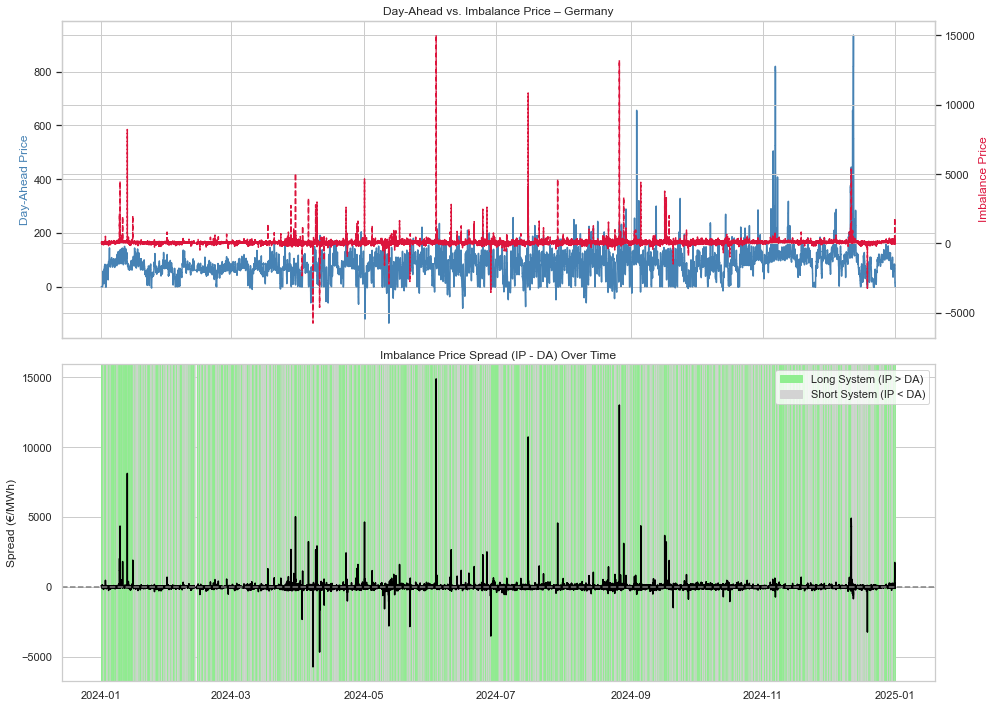

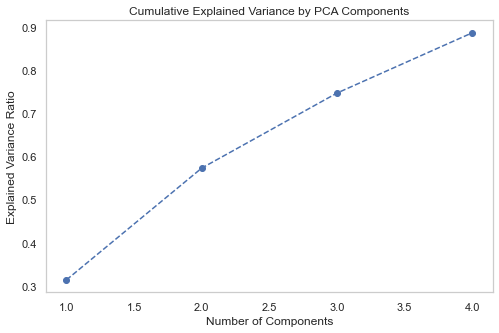

The first four principal components explain 88.64% of the variance.


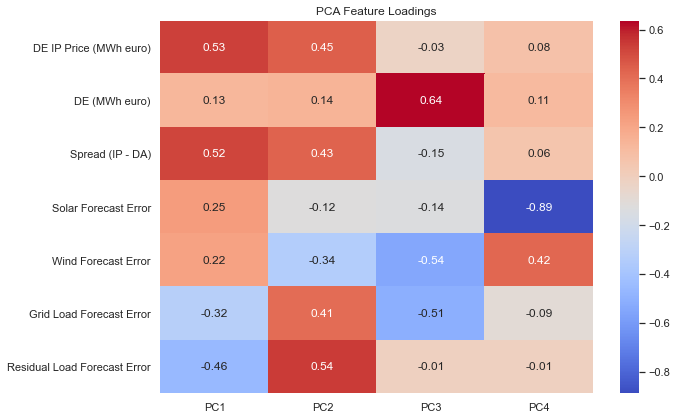

In [20]:
# ===========================================
# PART 22: DAY-AHEAD VS IMBALANCE PRICE ANALYSIS
# ===========================================

# Feature engineering
df["Spread (IP - DA)"] = df["DE IP Price (MWh euro)"] - df["DE (MWh euro)"]

# Plot DA vs IP Prices
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top plot: Prices
ax1.plot(df["Start date"], df["DE (MWh euro)"], label="Day-Ahead Price", color="steelblue")
ax1b = ax1.twinx()
ax1b.plot(df["Start date"], df["DE IP Price (MWh euro)"], label="Imbalance Price", color="crimson", linestyle="dashed")
ax1.set_ylabel("Day-Ahead Price", color="steelblue")
ax1b.set_ylabel("Imbalance Price", color="crimson")
ax1.set_title("Day-Ahead vs. Imbalance Price – Germany")

# Bottom plot: Spread with color area
green_patch = mpatches.Patch(color='lightgreen', label='Long System (IP > DA)')
grey_patch = mpatches.Patch(color='lightgrey', label='Short System (IP < DA)')
ax2.legend(handles=[green_patch, grey_patch], loc='upper right')

ax2.plot(df["Start date"], df["Spread (IP - DA)"], color="black", label="Spread (IP - DA)")
for i in range(len(df) - 1):
    color = "lightgreen" if df["Spread (IP - DA)"].iloc[i] > 0 else "lightgrey"
    ax2.axvspan(df["Start date"].iloc[i], df["Start date"].iloc[i+1], color=color, alpha=0.3)

ax2.axhline(0, color="grey", linestyle="--")
ax2.set_ylabel("Spread (€/MWh)")
ax2.set_title("Imbalance Price Spread (IP - DA) Over Time")

plt.tight_layout()
plt.show()

# ===========================================
# PART 23: PCA ANALYSIS ON IMBALANCE DATA
# ===========================================

# Additional features for PCA
df["Solar Forecast Error"] = df["DA Photovoltaics [MWh] forecast"] - df["Photovoltaics [MWh]"]
df["Wind Forecast Error"] = (
    df["DA Wind onshore [MWh] forecast"] + df["DA Wind offshore [MWh] forecast"]
) - (df["Wind onshore [MWh]"] + df["Wind offshore [MWh]"])
df["Grid Load Forecast Error"] = df["grid load [MWh] forecasted"] - df["grid load [MWh]"]
df["Residual Load Forecast Error"] = df["Residual load [MWh] forecasted"] - df["Residual load [MWh]"]

# Select PCA features
pca_features = [
    "DE IP Price (MWh euro)", "DE (MWh euro)", "Spread (IP - DA)",
    "Solar Forecast Error", "Wind Forecast Error",
    "Grid Load Forecast Error", "Residual Load Forecast Error"
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[pca_features].dropna())

# Run PCA
pca = PCA(n_components=4)
pca_components = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(pca_components, columns=["PC1", "PC2", "PC3", "PC4"])
df_pca["Start date"] = df["Start date"].iloc[-len(df_pca):].values

# PCA Variance Explained
plt.figure(figsize=(8, 5))
plt.plot(range(1, 5), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.show()

print(f"The first four principal components explain {np.sum(pca.explained_variance_ratio_):.2%} of the variance.")

# PCA Loadings (Feature Importance)
loadings = pd.DataFrame(pca.components_.T, index=pca_features, columns=["PC1", "PC2", "PC3", "PC4"])

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PCA Feature Loadings")
plt.tight_layout()
plt.show()



KMeans vs GMM Clustering Logic:
- KMeans assigns each point hard to one cluster center (distance-based)
- GMM assigns probabilities assuming Gaussian distributions (soft clustering)


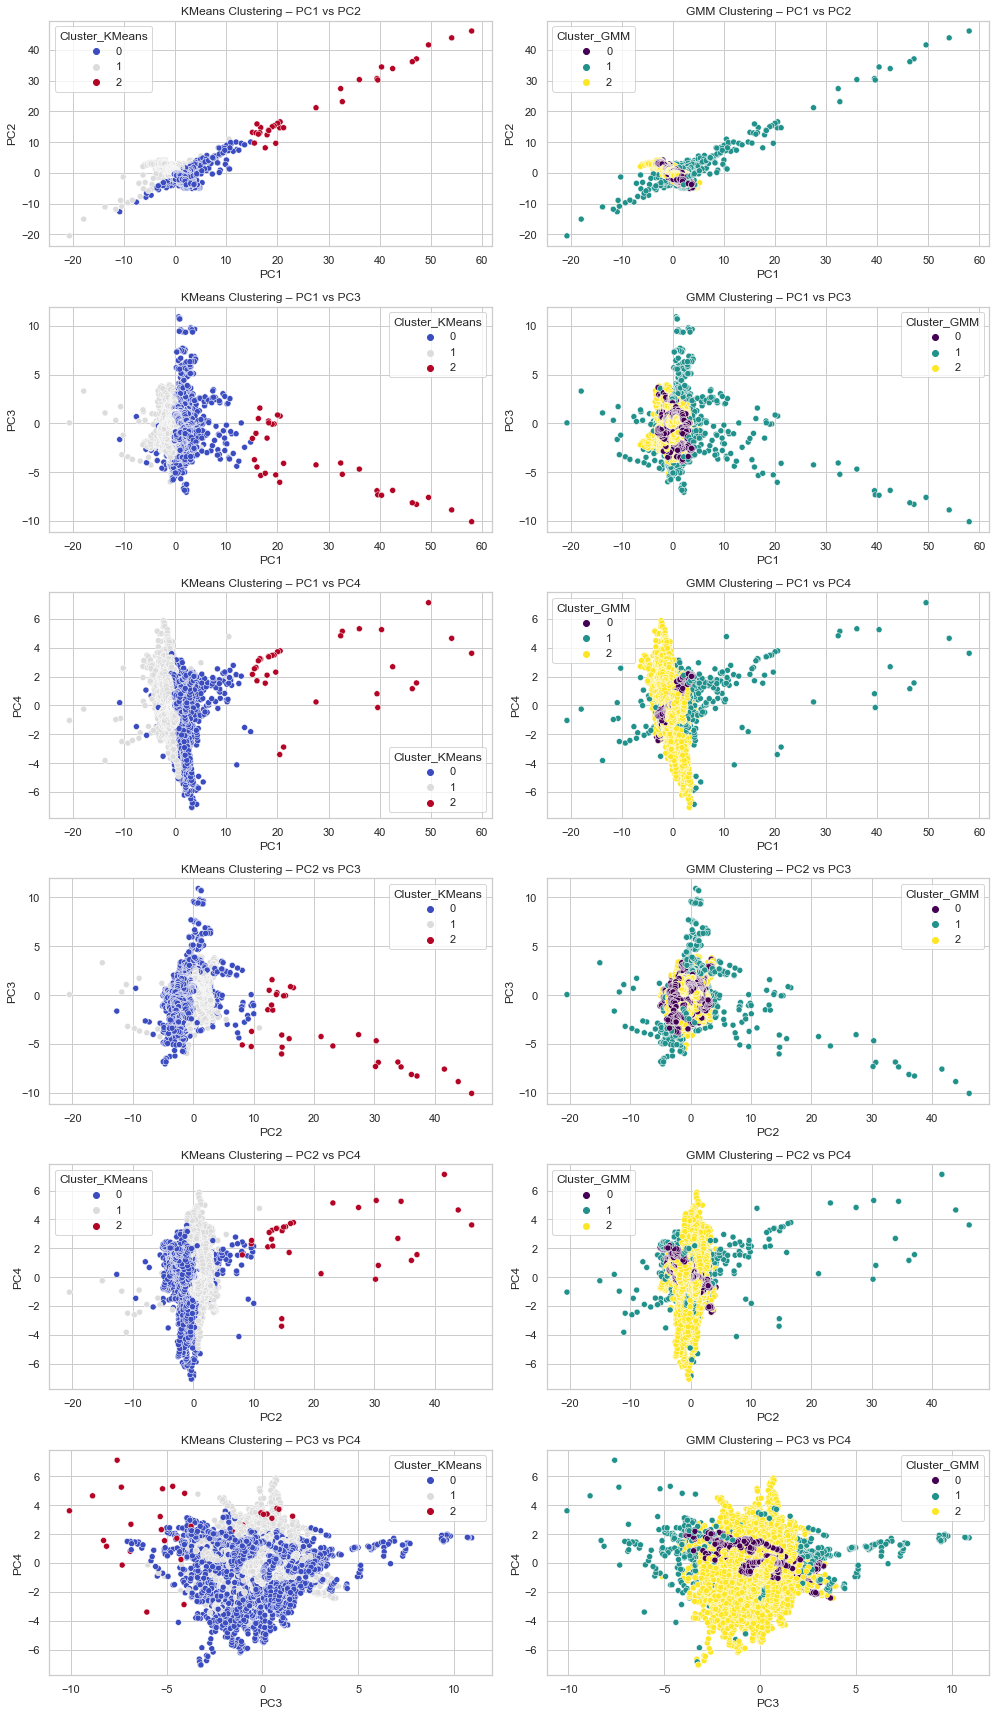


GMM Profitable Cluster Detected: 1

KMeans Low Vol Cluster Detected: 1
KMeans High Vol Cluster Detected: 2


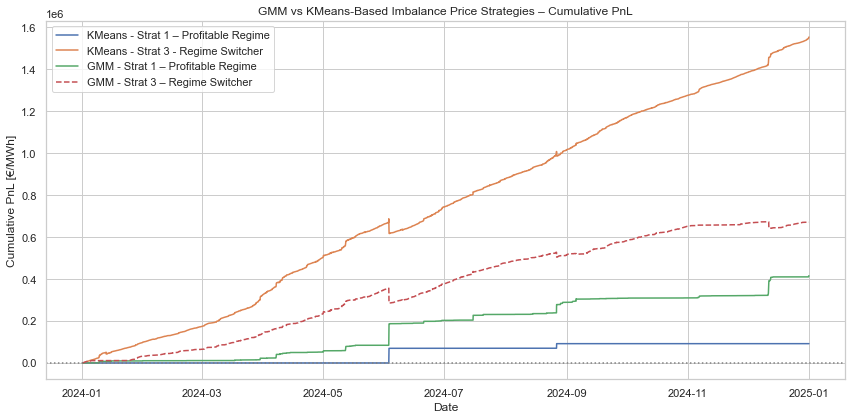


===== Strategy Performance Summary =====

GMM Strategy 1 – Profitable Regime Only:
Total PnL: €415,382.72, Trades: 759, Win Rate: 61.1%, Sharpe Ratio: 0.05
GMM Strategy 3 – Regime Switcher:
Total PnL: €671,108.03, Trades: 18753, Win Rate: 71.3%, Sharpe Ratio: 0.09

KMeans Strategy 1 – Profitable Regime Only:
Total PnL: €91,986.72, Trades: 13, Win Rate: 61.5%, Sharpe Ratio: 0.02
KMeans Strategy 3 – Regime Switcher:
Total PnL: €1,554,202.77, Trades: 34891, Win Rate: 75.1%, Sharpe Ratio: 0.18


In [23]:
# ===========================================
# PART 24: CLUSTERING WITH KMEANS AND GMM
# ===========================================

print("\nKMeans vs GMM Clustering Logic:")
print("- KMeans assigns each point hard to one cluster center (distance-based)")
print("- GMM assigns probabilities assuming Gaussian distributions (soft clustering)")


# Clustering on PCA components
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_pca["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=3, random_state=42)
df_pca["Cluster_GMM"] = gmm.fit_predict(X_scaled)

# Scatter plots for KMeans and GMM
import itertools

combinations = list(itertools.combinations(["PC1", "PC2", "PC3", "PC4"], 2))
fig, axes = plt.subplots(len(combinations), 2, figsize=(14, len(combinations) * 4))

for i, (pc_x, pc_y) in enumerate(combinations):
    sns.scatterplot(data=df_pca, x=pc_x, y=pc_y, hue="Cluster_KMeans", palette="coolwarm", ax=axes[i, 0])
    axes[i, 0].set_title(f"KMeans Clustering – {pc_x} vs {pc_y}")
    
    sns.scatterplot(data=df_pca, x=pc_x, y=pc_y, hue="Cluster_GMM", palette="viridis", ax=axes[i, 1])
    axes[i, 1].set_title(f"GMM Clustering – {pc_x} vs {pc_y}")

plt.tight_layout()
plt.show()

# ===========================================
# PART 25: TRADING STRATEGIES BASED ON REGIME SWITCHING
# ===========================================

# Merge clustering results
final_df = df.merge(df_pca[['Start date', 'Cluster_KMeans', 'Cluster_GMM']], on='Start date', how='left')
final_df['Spread (IP - DA)'] = final_df['DE IP Price (MWh euro)'] - final_df['DE (MWh euro)']

# ===================== GMM Clustering Analysis =====================

# Find profitable cluster dynamically (GMM)
gmm_cluster_mean_spreads = final_df.groupby('Cluster_GMM')['Spread (IP - DA)'].mean()
profitable_gmm_cluster = gmm_cluster_mean_spreads.idxmax()

print(f"\nGMM Profitable Cluster Detected: {profitable_gmm_cluster}")

# Strategy 1: Trade in Profitable Regime Only
final_df['Signal_ProfitOnly'] = final_df.apply(
    lambda row: 1 if row['Cluster_GMM'] == profitable_gmm_cluster and row['Spread (IP - DA)'] > 0 else
                -1 if row['Cluster_GMM'] == profitable_gmm_cluster and row['Spread (IP - DA)'] < 0 else 0,
    axis=1
)
final_df['PnL_ProfitOnly'] = final_df['Signal_ProfitOnly'].shift(1) * final_df['Spread (IP - DA)']
final_df['Cumulative PnL ProfitOnly'] = final_df['PnL_ProfitOnly'].cumsum()

# Strategy 3: Volatility Regime Switcher (based on KMeans)
# Detect low vol and high vol clusters dynamically
kmeans_volatility = final_df.groupby('Cluster_KMeans')['Spread (IP - DA)'].std()
low_vol_cluster = kmeans_volatility.idxmin()
high_vol_cluster = kmeans_volatility.idxmax()

print(f"\nKMeans Low Vol Cluster Detected: {low_vol_cluster}")
print(f"KMeans High Vol Cluster Detected: {high_vol_cluster}")

def regime_strategy(row):
    if row['Cluster_KMeans'] == low_vol_cluster:
        return 1 if row['Spread (IP - DA)'] > 0 else -1
    elif row['Cluster_KMeans'] == high_vol_cluster:
        return -1 if row['Spread (IP - DA)'] > 0 else 1
    else:
        return 0

final_df['Signal_RegimeSwitch'] = final_df.apply(regime_strategy, axis=1)
final_df['PnL_RegimeSwitch'] = final_df['Signal_RegimeSwitch'].shift(1) * final_df['Spread (IP - DA)']
final_df['Cumulative PnL RegimeSwitch'] = final_df['PnL_RegimeSwitch'].cumsum()

# ===================== KMeans Clustering Analysis =====================

# Reuse PCA features
df["Spread (IP - DA)"] = df["DE IP Price (MWh euro)"] - df["DE (MWh euro)"]
df["Volatility"] = df["Spread (IP - DA)"].rolling(window=24).std()

features = ["Spread (IP - DA)", "Volatility"]
df_cluster = df.dropna(subset=features).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)
df = df.merge(df_cluster[["Start date", "Cluster_KMeans"]], on="Start date", how="left")

# Find profitable cluster dynamically (KMeans)
kmeans_cluster_mean_spreads = df.groupby('Cluster_KMeans')["Spread (IP - DA)"].mean()
profitable_kmeans_cluster = kmeans_cluster_mean_spreads.idxmax()

# Strategy 1 – Profitable Cluster (KMeans)
df["Signal_KMeans_Strat1"] = df.apply(
    lambda row: np.sign(row["Spread (IP - DA)"]) if row["Cluster_KMeans"] == profitable_kmeans_cluster else 0, axis=1
)
df["PnL_KMeans_Strat1"] = df["Signal_KMeans_Strat1"].shift(1) * df["Spread (IP - DA)"]
df["Cumulative_PnL_KMeans_Strat1"] = df["PnL_KMeans_Strat1"].cumsum()

# Strategy 3 – Regime Switcher (KMeans)
low_vol_cluster_kmeans = df.groupby("Cluster_KMeans")["Volatility"].mean().idxmin()
high_vol_cluster_kmeans = df.groupby("Cluster_KMeans")["Volatility"].mean().idxmax()

def strat3_kmeans(row):
    if row["Cluster_KMeans"] == low_vol_cluster_kmeans:
        return np.sign(row["Spread (IP - DA)"])  # momentum
    elif row["Cluster_KMeans"] == high_vol_cluster_kmeans:
        return -np.sign(row["Spread (IP - DA)"])  # mean-reversion
    else:
        return 0

df["Signal_KMeans_Strat3"] = df.apply(strat3_kmeans, axis=1)
df["PnL_KMeans_Strat3"] = df["Signal_KMeans_Strat3"].shift(1) * df["Spread (IP - DA)"]
df["Cumulative_PnL_KMeans_Strat3"] = df["PnL_KMeans_Strat3"].cumsum()

# ===================== Metrics =====================
def evaluate_strategy(signal_col, pnl_col, dataset):
    trades = dataset[signal_col] != 0
    n_trades = trades.sum()
    win_rate = (dataset.loc[trades, pnl_col] > 0).mean()
    sharpe = dataset[pnl_col].mean() / dataset[pnl_col].std()
    total_pnl = dataset[pnl_col].sum()
    return total_pnl, n_trades, win_rate, sharpe

metrics_gmm_1 = evaluate_strategy('Signal_ProfitOnly', 'PnL_ProfitOnly', final_df)
metrics_gmm_3 = evaluate_strategy('Signal_RegimeSwitch', 'PnL_RegimeSwitch', final_df)
metrics_kmeans_1 = evaluate_strategy('Signal_KMeans_Strat1', 'PnL_KMeans_Strat1', df)
metrics_kmeans_3 = evaluate_strategy('Signal_KMeans_Strat3', 'PnL_KMeans_Strat3', df)

# ===================== PnL Plots =====================
plt.figure(figsize=(12, 6))
plt.plot(df["Start date"], df["Cumulative_PnL_KMeans_Strat1"], label='KMeans - Strat 1 – Profitable Regime')
plt.plot(df["Start date"], df["Cumulative_PnL_KMeans_Strat3"], label='KMeans - Strat 3 - Regime Switcher')
plt.plot(final_df['Start date'], final_df['Cumulative PnL ProfitOnly'], label='GMM - Strat 1 – Profitable Regime')
plt.plot(final_df['Start date'], final_df['Cumulative PnL RegimeSwitch'], label='GMM - Strat 3 – Regime Switcher', linestyle='--')
plt.axhline(0, linestyle=':', color='gray')
plt.title("GMM vs KMeans-Based Imbalance Price Strategies – Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL [€/MWh]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===================== Performance Printout =====================
print("\n===== Strategy Performance Summary =====\n")
print(f"GMM Strategy 1 – Profitable Regime Only:\nTotal PnL: €{metrics_gmm_1[0]:,.2f}, Trades: {metrics_gmm_1[1]}, Win Rate: {metrics_gmm_1[2]*100:.1f}%, Sharpe Ratio: {metrics_gmm_1[3]:.2f}")
print(f"GMM Strategy 3 – Regime Switcher:\nTotal PnL: €{metrics_gmm_3[0]:,.2f}, Trades: {metrics_gmm_3[1]}, Win Rate: {metrics_gmm_3[2]*100:.1f}%, Sharpe Ratio: {metrics_gmm_3[3]:.2f}\n")
print(f"KMeans Strategy 1 – Profitable Regime Only:\nTotal PnL: €{metrics_kmeans_1[0]:,.2f}, Trades: {metrics_kmeans_1[1]}, Win Rate: {metrics_kmeans_1[2]*100:.1f}%, Sharpe Ratio: {metrics_kmeans_1[3]:.2f}")
print(f"KMeans Strategy 3 – Regime Switcher:\nTotal PnL: €{metrics_kmeans_3[0]:,.2f}, Trades: {metrics_kmeans_3[1]}, Win Rate: {metrics_kmeans_3[2]*100:.1f}%, Sharpe Ratio: {metrics_kmeans_3[3]:.2f}")